<a href="https://colab.research.google.com/github/diksha139/105StudentActivity/blob/main/House_price_prediction_model_Hackathon_Group_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!!pip install pyspark scikit-learn seaborn flask numpy pandas matplotlib

['Requirement already satisfied: pyspark in /usr/local/lib/python3.10/dist-packages (3.5.0)',
 'Requirement already satisfied: scikit-learn in /usr/local/lib/python3.10/dist-packages (1.2.2)',
 'Requirement already satisfied: seaborn in /usr/local/lib/python3.10/dist-packages (0.12.2)',
 'Requirement already satisfied: flask in /usr/local/lib/python3.10/dist-packages (2.2.5)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (1.23.5)',
 'Requirement already satisfied: pandas in /usr/local/lib/python3.10/dist-packages (1.5.3)',
 'Requirement already satisfied: matplotlib in /usr/local/lib/python3.10/dist-packages (3.7.1)',
 'Requirement already satisfied: py4j==0.10.9.7 in /usr/local/lib/python3.10/dist-packages (from pyspark) (0.10.9.7)',
 'Requirement already satisfied: scipy>=1.3.2 in /usr/local/lib/python3.10/dist-packages (from scikit-learn) (1.11.4)',
 'Requirement already satisfied: joblib>=1.1.1 in /usr/local/lib/python3.10/dist-packages (from sc

In [49]:
from google.colab import files
train_file = files.upload()

In [50]:
from google.colab import files
test_file = files.upload()

# **Importing** libraries

In [51]:


import numpy as np
import pandas as pd

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

from pyspark.sql.functions import lit
from pyspark.sql.types import FloatType, IntegerType

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

#Creating pyspark session


In [52]:

spark_session = SparkSession.builder.appName("HousingPriceRegression").getOrCreate()
spark_context = spark_session.sparkContext
spark_sql_context = SQLContext(spark_context)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#setting variable for csv files

In [53]:

TRAIN_INPUT = '/content/train.csv'
TEST_INPUT = '/content/test.csv'

In [54]:
#creating pandas dataframe
pd_train = pd.read_csv(TRAIN_INPUT)
pd_test = pd.read_csv(TEST_INPUT)
#columns with null values
na_cols = pd_train.columns[pd_train.isna().any()].tolist()
print(na_cols)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


# How SalePrice is distributed against normal theoretical quantiles

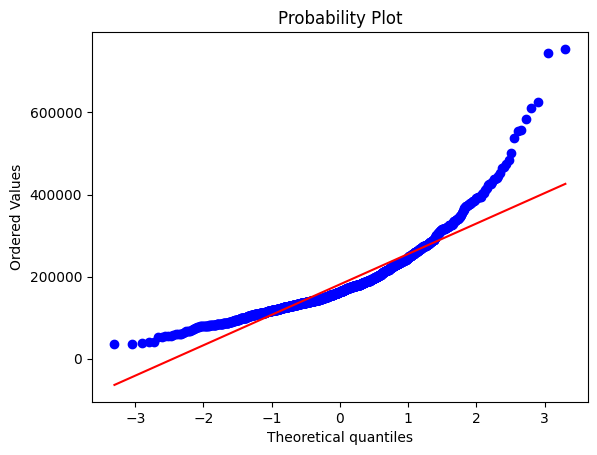

In [55]:

fig = plt.figure()
ax = fig.add_subplot()
res = stats.probplot(pd_train['SalePrice'], plot=plt)

#Scatter plot ('OverallQual vs SalePrice') & ('GarageCars vs SalePrice')

Text(0.5, 1.0, 'GarageCars vs SalePrice')

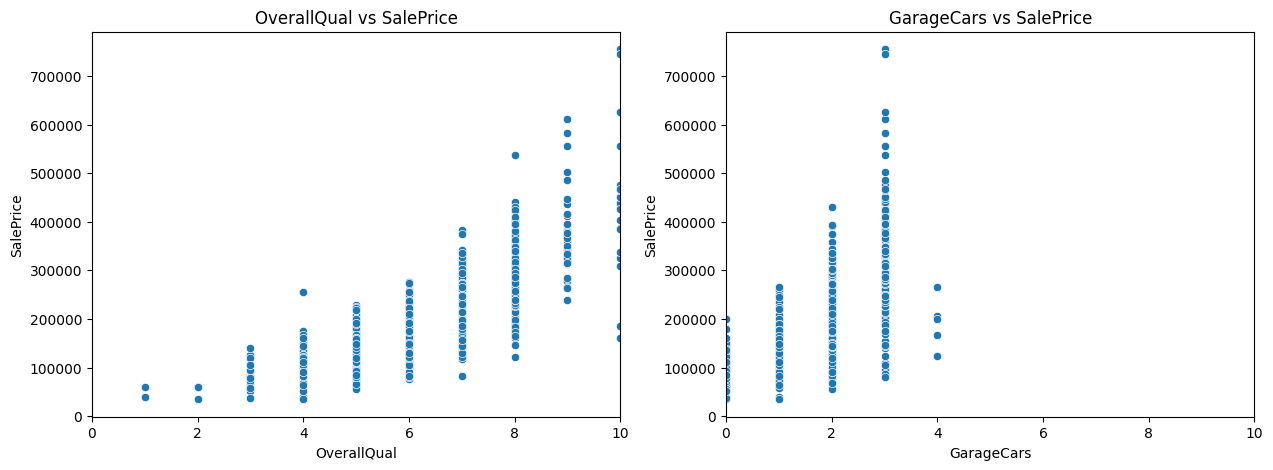

In [56]:

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0,10)

sns.scatterplot(data=pd_train, ax=axes[0], x='OverallQual', y='SalePrice')
axes[0].set_title('OverallQual vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='GarageCars', y='SalePrice')
axes[1].set_title('GarageCars vs SalePrice')

#Scatter plot ('GridLivArea vs SalePrice') & ('GarageArea vs SalePrice')

Text(0.5, 1.0, 'GarageArea vs SalePrice')

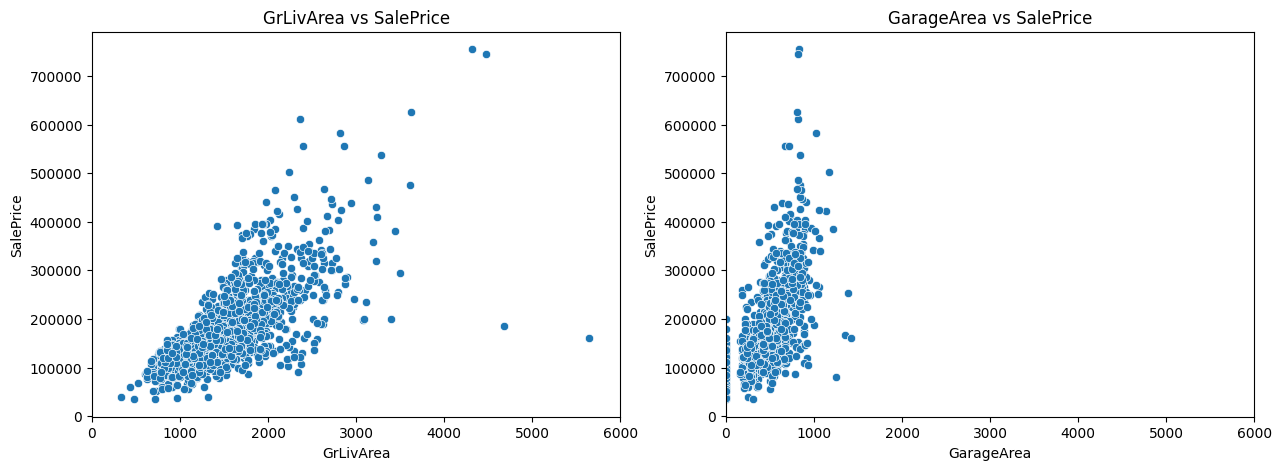

In [57]:

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=pd_train, ax=axes[0], x='GrLivArea', y='SalePrice')
axes[0].set_title('GrLivArea vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='GarageArea', y='SalePrice')
axes[1].set_title('GarageArea vs SalePrice')

#Scatter plot ('TotalBsmtSF vs SalePrice') & ('1stFlrSF vs SalePrice')

Text(0.5, 1.0, '1stFlrSF vs SalePrice')

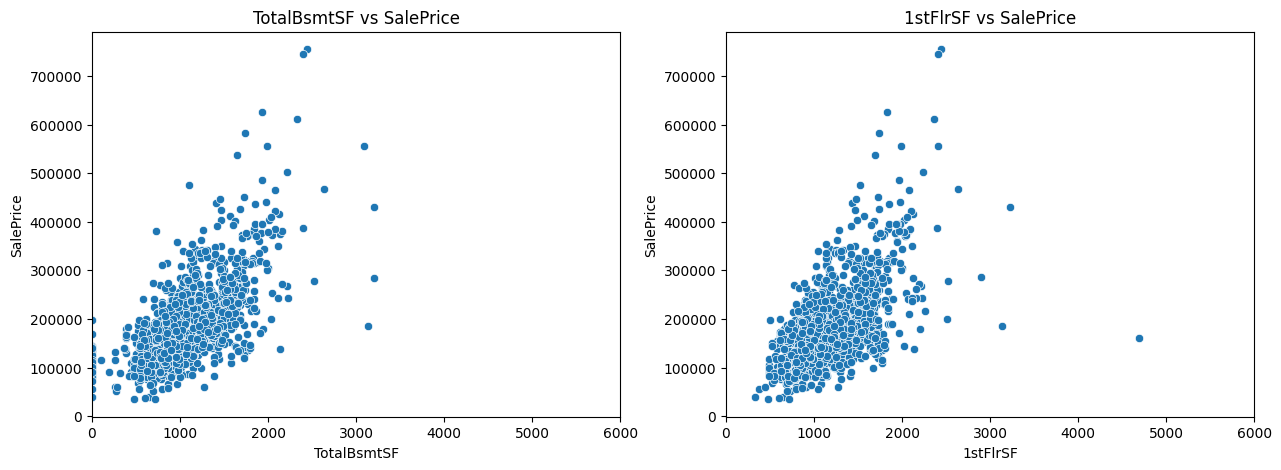

In [58]:

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=pd_train, ax=axes[0], x='TotalBsmtSF', y='SalePrice')
axes[0].set_title('TotalBsmtSF vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='1stFlrSF', y='SalePrice')
axes[1].set_title('1stFlrSF vs SalePrice')

#Scatter plot ('LotFrontage vs SalePrice') & ('Fence vs SalePrice')

Text(0.5, 1.0, 'Fence vs SalePrice')

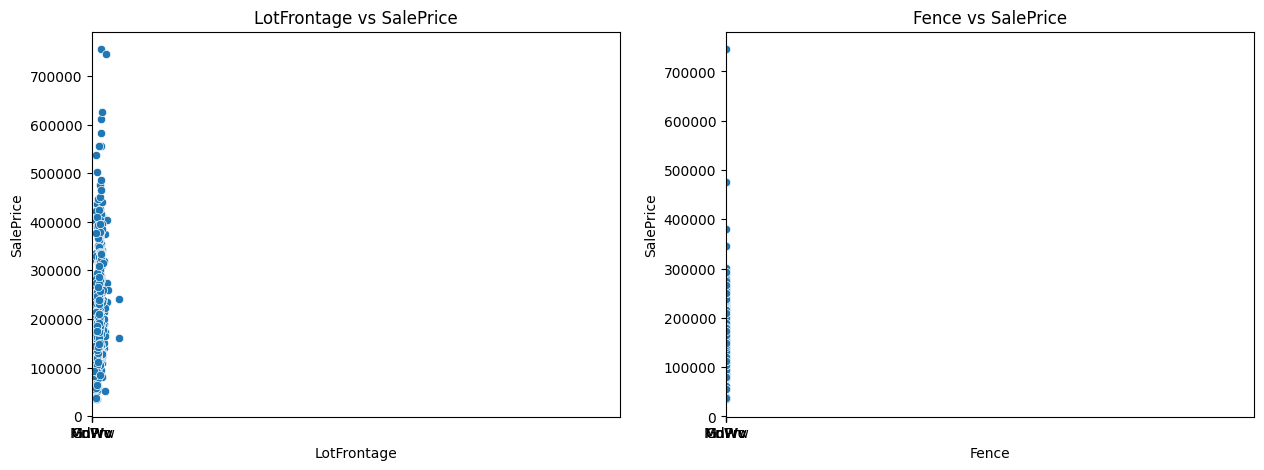

In [59]:

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=pd_train, ax=axes[0], x='LotFrontage', y='SalePrice')
axes[0].set_title('LotFrontage vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='Fence', y='SalePrice')
axes[1].set_title('Fence vs SalePrice')

# Finding missing values

In [60]:
#calculating the total number of missing values in each column of your Pandas DataFrame pd_train and sorting them in descending order
total = pd_train.isnull().sum().sort_values(ascending=False)
#calculating the percentage of missing values in each column of your Pandas DataFrame pd_train and sorting them in descending order
percent = (pd_train.isnull().sum()/pd_train.shape[0]).sort_values(ascending=False)
#combining the total count and percentage of missing values for each column in your Pandas DataFrame pd_train into a new DataFrame named missing
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Perc_missing'])
missing.head(15)

,Total,Perc_missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


# Dropping some columns

In [61]:
#dropping columns from your Pandas DataFrame pd_train where the percentage of missing values exceeds a threshold of  15% and removes columns with a high percentage of missing values.
pd_train = pd_train.drop(columns=(missing[missing['Perc_missing'] >= 0.15]).index)
pd_train.head()
pd_train.shape

(1460, 75)

# Creating new column


In [62]:
#creating a new column in your Pandas DataFrame pd_train and pd_test  named 'NewFeature', and populating it with the product of the values in the 'OverallQual', 'GarageArea', and 'GrLivArea' columns.
pd_train['NewFeature'] = pd_train['OverallQual'] * pd_train['GarageArea'] * pd_train['GrLivArea']
pd_test['NewFeature'] = pd_test['OverallQual'] * pd_test['GarageArea'] * pd_test['GrLivArea']

In [63]:
#creating a list named train_cols containing the column names of your Pandas DataFrame pd_train.
train_cols = list(pd_train.columns)
train_cols.remove('SalePrice')

In [64]:
#Make test ds feature set same as in train ds

pd_test = pd_test[train_cols]
pd_test.shape

(1459, 75)

# Missing value Interpretation

In [65]:
#identifying columns in your Pandas DataFrame pd_test that contain missing values (NaN)
pd_test.columns[pd_test.isna().any()].tolist()

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'SaleType',
 'NewFeature']

# Handling missing values

In [89]:
#handling missing values in specific columns for both training and test datasets (pd_train and pd_test and fillingit with calue "None"

for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    pd_train[col] = pd_train[col].fillna("None")
    pd_test[col] = pd_test[col].fillna("None")

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    pd_train[col] = pd_train[col].fillna("None")
    pd_test[col] = pd_test[col].fillna("None")

for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    pd_train[col] = pd_train[col].fillna(0)
    pd_test[col] = pd_test[col].fillna(0)


pd_train['MasVnrArea'] = pd_train['MasVnrArea'].fillna(0)
pd_test['MasVnrArea'] = pd_test['MasVnrArea'].fillna(0)

pd_train['Electrical'] = pd_train['Electrical'].fillna(pd_train['Electrical'].mode()[0])
pd_test['Electrical'] = pd_test['Electrical'].fillna(pd_test['Electrical'].mode()[0])


In [67]:
#prints the maximum count of missing values across all columns in the dataframe
print(pd_train.isnull().sum().max())
print(pd_test.isnull().sum().max())

8
16


#Filling missing values

In [68]:
#filling missing values in the below columns of your Pandas DataFrame pd_test with the mean value of that column
pd_test['BsmtFinSF1'] = pd_test['BsmtFinSF1'].fillna(pd_test['BsmtFinSF1'].mean())
pd_test['BsmtFinSF2'] = pd_test['BsmtFinSF2'].fillna(pd_test['BsmtFinSF2'].mean())
pd_test['BsmtUnfSF'] = pd_test['BsmtUnfSF'].fillna(pd_test['BsmtUnfSF'].mean())
pd_test['TotalBsmtSF'] = pd_test['TotalBsmtSF'].fillna(pd_test['TotalBsmtSF'].mean())
pd_test['BsmtFullBath'] = pd_test['BsmtFullBath'].fillna(pd_test['BsmtFullBath'].mean())
pd_test['BsmtHalfBath'] = pd_test['BsmtHalfBath'].fillna(pd_test['BsmtHalfBath'].mean())

<ipython-input-68-7407f8803355>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_test['BsmtFinSF1'] = pd_test['BsmtFinSF1'].fillna(pd_test['BsmtFinSF1'].mean())
<ipython-input-68-7407f8803355>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_test['BsmtFinSF2'] = pd_test['BsmtFinSF2'].fillna(pd_test['BsmtFinSF2'].mean())


In [69]:
#column names of categorical variables (columns with data type 'object')
cat_columns = pd_train.select_dtypes(include=['object']).columns
pd_train[cat_columns] = pd_train[cat_columns].fillna('NA')
pd_test[cat_columns] = pd_test[cat_columns].fillna('NA')

# Handling Outliers

In [70]:
#dropping outliers from your  train dataset based on below conditions
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[(pd_train['GrLivArea']>4000)
                                & (pd_train['SalePrice']<300000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[(pd_train['GrLivArea']>5000)
                                | (pd_train['SalePrice']>500000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[pd_train['GarageArea']>1000].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))

Dropping outliers resulted in 1460 instances in the new dataset
Dropping outliers resulted in 1458 instances in the new dataset
Dropping outliers resulted in 1449 instances in the new dataset
Dropping outliers resulted in 1437 instances in the new dataset


# Pandas DF to spark DataFrames

In [71]:
#converting your Pandas DataFrames to spark dataframes
train_df = spark_session.createDataFrame(pd_train)
test_df = spark_session.createDataFrame(pd_test)

In [72]:
#selecting columns in your Spark DataFrames (train_df and test_df) based on a list of columns that contain missing values (na_cols) and removing saleprice column from list of columns and selects only the columns listed in train_cols from the test_df DataFrame.

train_df = train_df.select([c for c in train_df.columns if c not in na_cols])
train_cols = train_df.columns
train_cols.remove('SalePrice')
test_df = test_df.select(train_cols)

In [73]:

#cast below columns in your Spark DataFrame (test_df) to the IntegerType

test_df = test_df.withColumn("BsmtFinSF1", test_df["BsmtFinSF1"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFinSF2", test_df["BsmtFinSF2"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtUnfSF", test_df["BsmtUnfSF"].cast(IntegerType()))
test_df = test_df.withColumn("TotalBsmtSF", test_df["TotalBsmtSF"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFullBath", test_df["BsmtFullBath"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtHalfBath", test_df["BsmtHalfBath"].cast(IntegerType()))
test_df = test_df.withColumn("GarageCars", test_df["GarageCars"].cast(IntegerType()))
test_df = test_df.withColumn("GarageArea", test_df["GarageArea"].cast(IntegerType()))

# Defining Categorical Attributes

In [74]:
# Defining string columns to pass on to the String Indexer (= categorical feature encoding)
#identifying columns with a data type of 'string' in Spark DataFrame train_df to list  train_string_columns
train_string_columns = []

for col, dtype in train_df.dtypes:
    if dtype == 'string':
        train_string_columns.append(col)
print(train_string_columns)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


# Using pyspark String Indexer

In [75]:
# PySpark's StringIndexer to convert categorical columns with string values into numerical indices in your Spark DataFrame train_df.
indexers = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(train_df) for column in train_string_columns]
pipeline = Pipeline(stages=indexers)
train_indexed = pipeline.fit(train_df).transform(train_df)

In [76]:
len(train_indexed.columns)

90

In [77]:
#identifying columns with a data type of 'string' in Spark DataFrame test_df to list  test_string_columns
test_string_columns = []
for col, dtype in test_df.dtypes:
    if dtype == 'string':
        test_string_columns.append(col)
print(test_string_columns)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


In [78]:
#PySpark's StringIndexer to convert categorical columns with string values into numerical indices in your Spark DataFrame test_df.
indexers2 = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(test_df) for column in test_string_columns]
pipeline2 = Pipeline(stages=indexers2)
test_indexed = pipeline2.fit(test_df).transform(test_df)

In [79]:
len(test_indexed.columns)

89

In [80]:
#identifying and selecting numerical columns in your Spark DataFrames (train_indexed and test_indexed)  using get_dtype function

def get_dtype(df,colname):
    return [dtype for name, dtype in df.dtypes if name == colname][0]

num_cols_train = []
for col in train_indexed.columns:
    if get_dtype(train_indexed,col) != 'string':
        num_cols_train.append(str(col))

num_cols_test = []
for col in test_indexed.columns:
    if get_dtype(test_indexed,col) != 'string':
        num_cols_test.append(str(col))

train_indexed = train_indexed.select(num_cols_train)
test_indexed = test_indexed.select(num_cols_test)

In [81]:
print(len(train_indexed.columns))
print(len(test_indexed.columns))

63
62


#PySpark's VectorAssembler to assemble the features into a single vector column features

In [82]:
#PySpark's VectorAssembler to assemble the features into a single vector column features in Spark DataFrame train_indexed.
vectorAssembler = VectorAssembler(inputCols = train_indexed.drop("SalePrice").columns, outputCol = 'features').setHandleInvalid("keep")
train_vector = vectorAssembler.transform(train_indexed)

In [83]:
#PySpark's VectorAssembler to assemble the features into a single vector column features  Spark DataFrame test_indexed.
vectorAssembler2 = VectorAssembler(inputCols = test_indexed.columns, outputCol = 'features').setHandleInvalid("keep")
test_vector = vectorAssembler2.transform(test_indexed)

In [84]:
#adding a new column named "SalePrice" to your Spark DataFrame test_vector and populating it with a constant value of 0 using the lit function
test_vector = test_vector.withColumn("SalePrice", lit(0))

In [85]:
#splitting  training data (train_vector) into training and validation sets using PySpark's randomSplit methood and are stored in the train and val DataFrames.

splits = train_vector.randomSplit([0.7, 0.3])
train = splits[0]
val = splits[1]

# PySpark's RandomForestRegressor to train a random forest model

In [90]:
# PySpark's RandomForestRegressor to train a random forest model and evaluating it on the validation set.



rf = RandomForestRegressor(featuresCol = 'features', labelCol='SalePrice',
                           maxDepth=15,
                           minInstancesPerNode=10,
                           bootstrap=True
                          )

# Create a Pipeline with your model
pipeline = Pipeline(stages=[rf])

# Fit the model
rf_model = pipeline.fit(train)

# Save the model
rf_model.write().overwrite().save("model/houseprice_predict_model")

rf_predictions = rf_model.transform(val)
rf_predictions.select("prediction","SalePrice","features").show(5)


rf_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="SalePrice",metricName="r2")
print("R Squared (R2) on val data = %g" % rf_evaluator.evaluate(rf_predictions))

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|203487.23293928296|   208500|(62,[0,1,2,3,4,5,...|
|221456.73746596285|   140000|(62,[0,1,2,3,4,5,...|
|117157.07216337584|   118000|(62,[0,1,2,3,4,5,...|
|341014.82513810706|   345000|(62,[0,1,2,3,4,5,...|
|133624.13375968396|   132000|(62,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.893288


In [92]:
#Using RF model to make predictions on the test dataset (test_vector) and preparing the results for submission
rf_predictions2 = rf_model.transform(test_vector)
#rf_predictions2.printSchema()
pred = rf_predictions2.select("Id","prediction")
pred = pred.withColumnRenamed("prediction","SalePrice")

pred = pred.withColumn("Id", pred["Id"].cast(IntegerType()))
pred = pred.withColumn("SalePrice", pred["SalePrice"].cast(FloatType()))

# Saving the results in .csv

In [91]:
#Converting the PySpark DataFrame pred to a Pandas DataFrame (pred_pd) and then saving it to a CSV file named "submission.csv".
pred_pd = pred.toPandas()
save = pred_pd.to_csv("submission.csv", index=False)
print(pred_pd)

        Id      SalePrice
0     1461  135606.671875
1     1462  164141.250000
2     1463  165779.171875
3     1464  192944.500000
4     1465  184733.000000
...    ...            ...
1454  2915  130686.875000
1455  2916  138241.671875
1456  2917  163541.000000
1457  2918  117317.085938
1458  2919  228539.062500

[1459 rows x 2 columns]


In [94]:
from google.colab import files
files.download("/content/model/houseprice_predict_model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>